# CMIP6 ECS Calculation from Pangeo Gallery
Within this notebook, we replicate the "Estimating Equilibrium Climate Sensitivity (ECS) in CMIP6 Models" example notebook from the [Pangeo Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/ECS_Gregory_method.html)

From their original example, here is the definition of Equilibrium Climate Sensivity

"Definition: **Equilibrium Climate Sensitivity** is defined as change in global-mean near-surface air temperature (GMST) change due to an instantaneous doubling of CO concentrations and once the coupled ocean-atmosphere-sea ice system has acheived a statistical equilibrium (i.e. at the top-of-atmosphere, incoming solar shortwave radiation is balanced by reflected solar shortwave and outgoing thermal longwave radiation).

This notebook uses the [“Gregory method”](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2003GL018747) to approximate the ECS of CMIP6 models based on the first 150 years after an abrupt quadrupling of CO concentrations. The “Gregory Method” extrapolates the quasi-linear relationship between GMST and radiative imbalance at the top-of-atmosphere to estimate how much warming would occur if the system were in radiative balance at the top-of-atmosphere, which is by definition the equilibrium response. In particular, we extrapolate the linear relationship that occurs between 100 and 150 years after the abrupt quadrupling. Since the radiative forcing due to CO is a logarithmic function of the CO concentration, the GMST change from a first doubling is roughly the same as for a second doubling (to first order, we can assume feedbacks as constant), which means that the GMST change due to a quadrupling of CO is roughly ![ecs calc](ecs_equation.png). See also [Mauritsen et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018MS001400) for a detailed application of the Gregory Method (with modifications) for the case of one specific CMIP6 model, the MPI-M Earth System Model.

For another take on applying the Gregory method to estimate ECS, see [Angeline Pendergrass’ code.](https://github.com/apendergrass/cmip6-ecs)"

The purpose of reproducing this is to show that we can do so using the following tools:
* [`xpersist`](https://xcollection.readthedocs.io/en/latest/)
* [`Prefect`](https://www.prefect.io/)
* [`intake-esm`](https://intake-esm.readthedocs.io/en/stable/)

## Imports
We start **first** with some imports related to the caching functionality in [`xpersist`](https://github.com/NCAR/xpersist)

In [1]:
import os

os.environ["PREFECT__FLOWS__CHECKPOINTING"] = "True"

import tempfile
import time

import prefect
import xcollection as xc
from prefect import Flow, Parameter, task, unmapped
from xpersist import CacheStore, XpersistResult

prefect.context.to_dict()['config']['flows']['checkpointing']

True

Next, we install the rest of our libraries/packages

In [2]:
import warnings

import cartopy
import cf_xarray
import dask
import fsspec
import intake
import numpy as np
import pandas as pd
import xarray as xr
from distributed import Client
from matplotlib import pyplot as plt
from ncar_jobqueue import NCARCluster
from tqdm.autonotebook import tqdm

warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
xr.set_options(keep_attrs=True)
%config InlineBackend.figure_format = 'retina'

/glade/u/home/mgrover/.local/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/u/home/mgrover/.local/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/u/home/mgrover/.local/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/u/home/mgrover/.local/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use da

## Spin up a Dask Cluster
We use a `Dask.Cluster` here to apply our computation

In [3]:
cluster = NCARCluster()
cluster.scale(20)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:33401,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read in our data using an `Intake-esm` Catalog
We load in the "Pangeo CMIP6 Catalog". A summary of this catalog is provided below:


"This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6).

The file https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment’s simulated data.

For example, the first line in the csv file contains the precipitation rate (variable_id = 'pr'), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (source_id = 'BCC-ESM1') developed by the Beijing Climate Center (institution_id = 'BCC'). The model is forced by the forcing experiment SSP370 (experiment_id = 'ssp370'), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of  W/m from pre-industrial to 2100. This simulation was run as part of the AerChemMIP activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate."


In [4]:
data_catalog = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json",
)

### Query for the `piControl` and `abrupt-4xCO2` experiments

Here, we choose the `piControl` experiment (in which CO2 concentrations are held fixed at a pre-industrial level of ~300 ppm) and `abrupt-4xCO2` experiment (in which CO2 concentrations are instantaneously quadrupled - or doubled twice - from a pre-industrial controrl state). Since the radiative forcing of CO2 is roughly a logarithmic function of CO2 concentrations, the ECS is roughly independent of the initial CO2 concentration. Thus, if one doubling of CO2 results in  of warming, then two doublings (or, a quadrupling) results in  of warming.

Ideally, we would choose the `abrupt-2xCO2` forcing experiment, but more `4xCO2` data are currently avaiable in Google Cloud Storage, making for a better example.

We also look for a single `source_id`, for simplicity

In [5]:
query = dict(
    experiment_id=[
        'abrupt-4xCO2',
        'piControl',
    ],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',  # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=[
        'tas',
        'rsut',
        'rsdt',
        'rlut',
    ],  # choose to look at near-surface air temperature (tas) as our variable
    member_id='r1i1p1f1',
    source_id='ACCESS-CM2',  # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)
col_subset = data_catalog.search(**query)
col_subset.df.groupby("source_id")['member_id'].unique()
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
2,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
3,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
4,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
5,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
6,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
7,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112


### Load in the data using `.to_collection()`
We can now load in our subset of the original catalog, reading it in as an `xcollection`, which is a more sophisticated dictionary of datasets

In [6]:
collection = col_subset.to_collection(storage_options={'anon': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## Define Operators
We are now ready to define some "operators" which are functions which operate on `xarray.Datasets`...

The key here is that they read in an `xarray.Dataset`, and return an `xarray.Dataset`

In [7]:
def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds.cf['latitude']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)


def yearly_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out


def imbalance(ds):
    ds['imbalance'] = ds.rsdt - ds.rsut - ds.rlut
    ds['imbalance'].attrs['long_name'] = 'Global Mean Radiative Imbalance'
    ds['imbalance'].attrs['units'] = 'W m$^{-2}$'
    return ds

### Compute anomalies based on the "piControl" run

In [8]:
pi_control = collection['CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn']

In [9]:
anom_collection = xc.Collection()
for key in collection.keys():
    anom_collection[key] = collection[key] - pi_control.mean(dim='time')

### Apply our operators to our `xcollections`
We can apply our operators using the `.map()` syntax

In [10]:
ecs_collection = collection.map(yearly_mean).map(global_mean).map(imbalance)
ecs_collection_anom = anom_collection.map(yearly_mean).map(global_mean).map(imbalance)

In [11]:
print(ecs_collection)
print(ecs_collection_anom)

<Collection (2 keys)>
🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn
<xarray.Dataset>
Dimensions:    (time: 500)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1449-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    imbalance  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn
<xarray.Dataset>
Dimensions:    (time: 150)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1099-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut    

## Plot the Fields

We start by subsetting for the first 150 years

In [12]:
first_150_years = slice(0, 149)

We setup another function to visualize our data, working at the dataset level

In [13]:
def plot_field(ds, field, time_subset=first_150_years, ax=None, label='', title=''):
    ds.isel(time=time_subset)[field].plot(ax=ax, label=label)
    plt.ylabel(f'{ds[field].long_name} \n Units: {ds[field].units}')
    plt.xlabel('Year')
    plt.legend()
    plt.title(title)
    return ds

It might be helpful to have a function that also works at the `xcollection.Collection` level!

In [14]:
def plot_collection(
    collection, field, time_subset=first_150_years, fig=None, ax=None, label=None, title=None
):
    if fig is None:
        fig = plt.figure(figsize=(10, 8))
    if ax is None:
        ax = plt.subplot(111)
    for key in ecs_collection.keys():
        plot_field(ecs_collection[key], field='tas', label=key, ax=ax, title=title)

    return fig

We can use `.map()` again in this case!

One of the variables used within the `ECS` calculation is `tas`, which temperature near the surface (2 meters above the ground)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


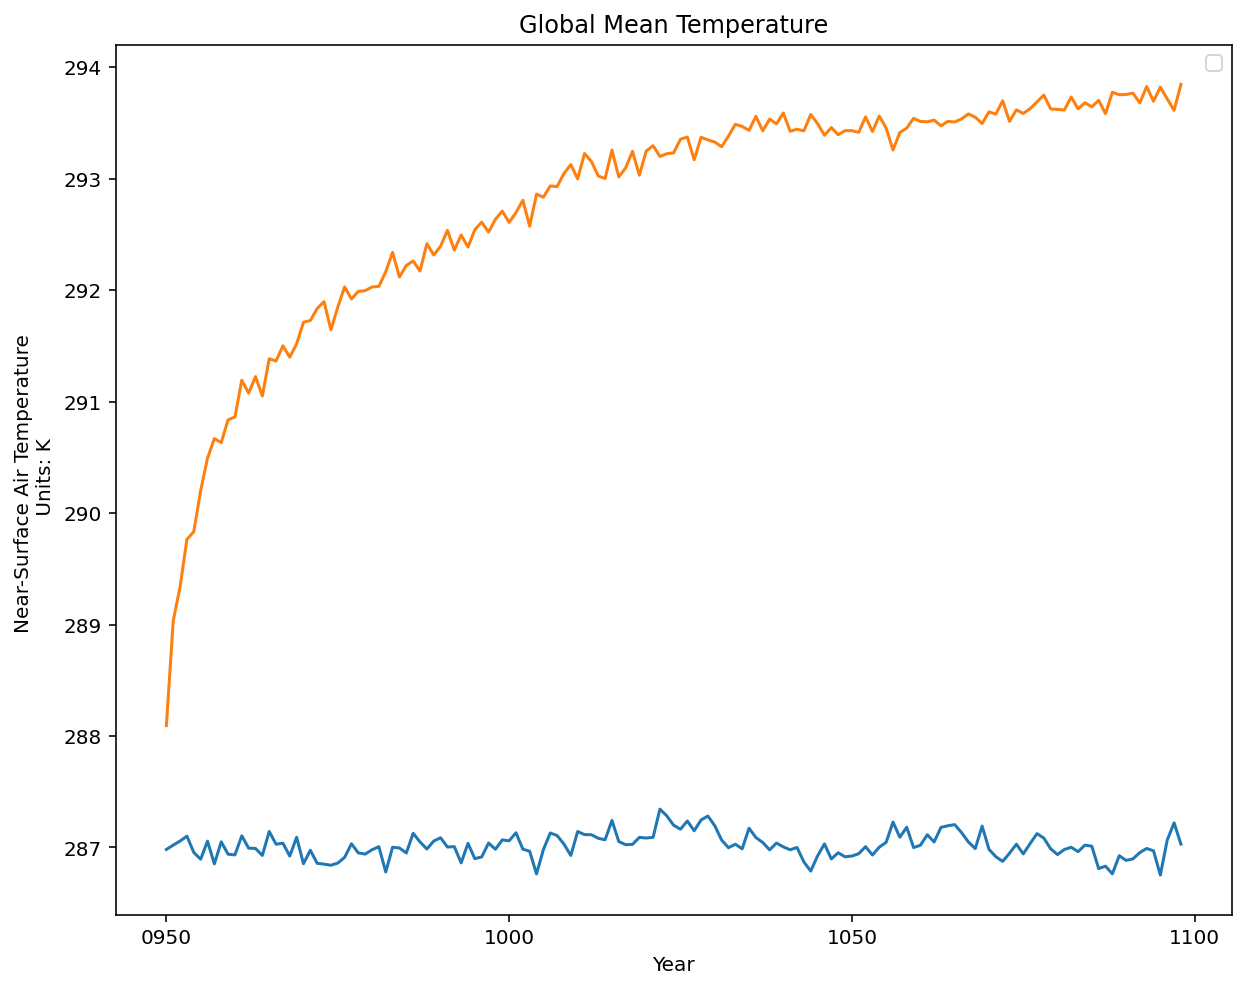

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
ecs_collection.map(plot_field, field='tas', ax=ax, title='Global Mean Temperature')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


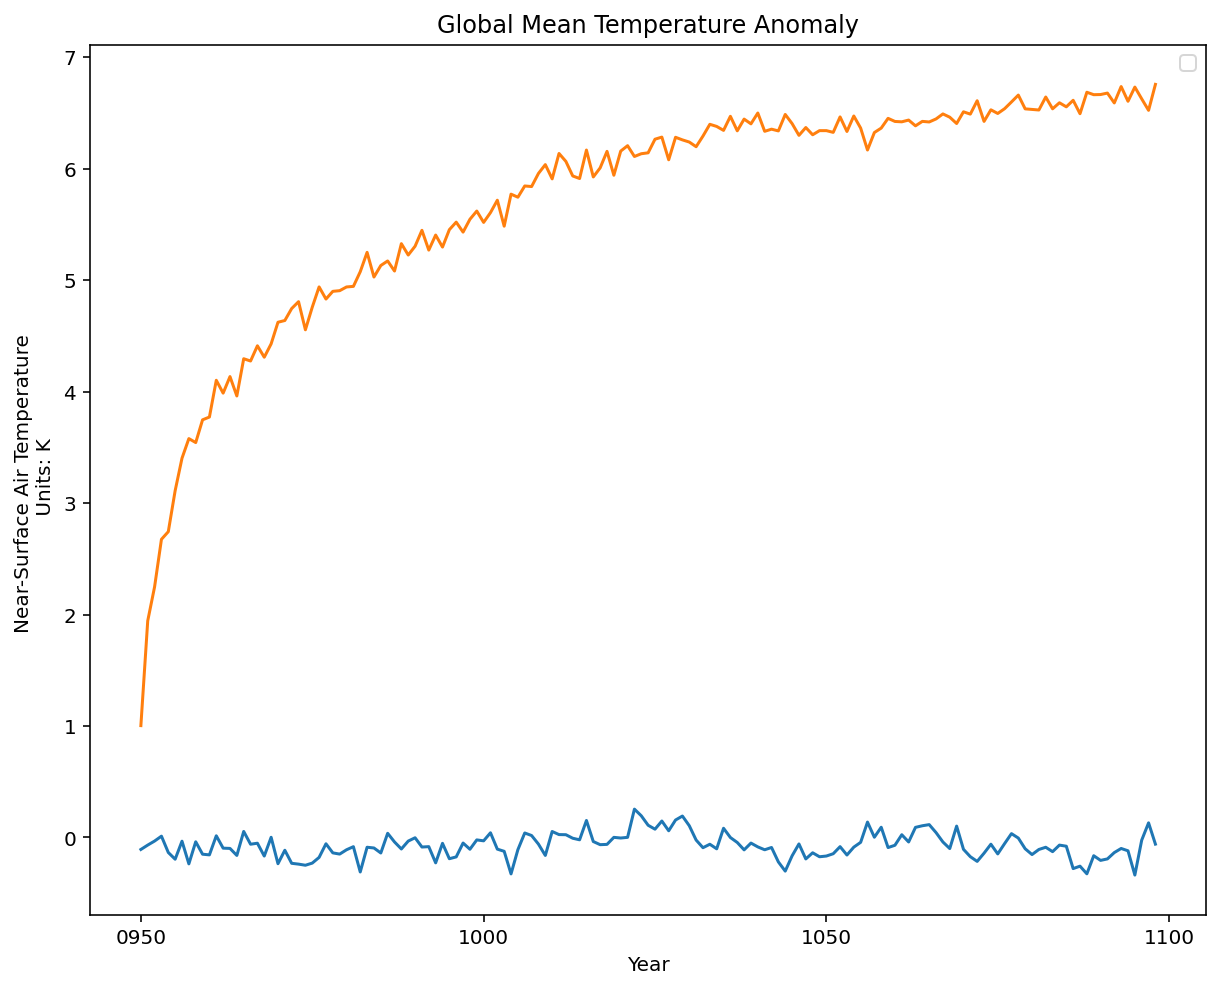

In [16]:
fig = plt.figure(figsize=(10, 8))
ecs_collection_anom.map(plot_field, field='tas', title='Global Mean Temperature Anomaly')
plt.show()

Let's try out the plotting at the collection level as well!

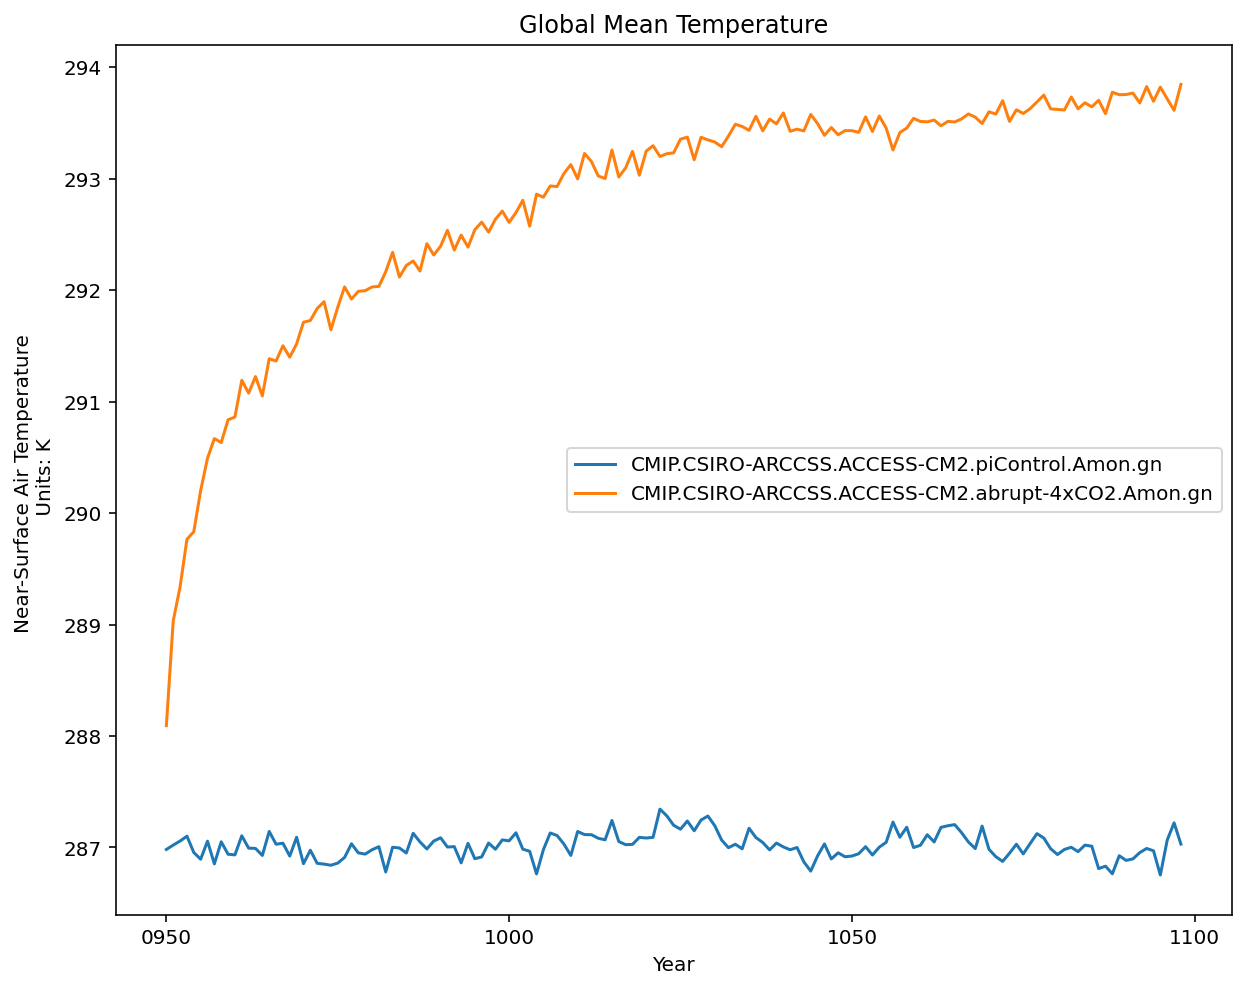

In [17]:
fig = plot_collection(ecs_collection, field='tas', title='Global Mean Temperature')

### Calculate Equilibrium Climate Sensitivity (ECS)
Our last calculation is ECS, which can be computed using the anomaly collection

Now, we can compute ECS, using the equation stated towards the beginning of this notebook

In [18]:
def calc_ecs(ds):
    ds = ds.isel(time=first_150_years)

    # Some sources don't have all 150 years, drop those missing values.
    a, b = np.polyfit(ds.tas.dropna("time"), ds.imbalance.dropna("time"), 1)
    ecs = -0.5 * (b / a)
    return xr.DataArray(ecs).to_dataset(name='ecs')

In [19]:
ecs = calc_ecs(ecs_collection_anom['CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn'])
ecs

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ecs      float64 4.683

## Writing this as a Prefect Workflow
We can now write this as a `Prefect` workflow!

### Setup your Cache Location

In [20]:
store = CacheStore(f'{tempfile.gettempdir()}/my-cache-2')
store

CacheStore(path='/glade/scratch/mgrover/my-cache-2', readonly=False, on_duplicate_key=<DuplicateKeyEnum.skip: 'skip'>, storage_options={})

### Setup your Tasks
Now that we have our `CacheStore` setup, we can put together some `tasks`

In [66]:
@task
def read_catalog(path, multivar_row=False):
    """
    Reads in an intake-esm catalog from a given path

    Parameters
    ----------
    path: str, path to the associated intake-esm catalog json

    multivar_row: boolean, default=False, whether multiple variables are in each row

    Returns
    -------
    intake_esm.Catalog
    """
    if multivar_row:
        read_csv_kwargs = {"converters": {"variables": ast.literal_eval}}
    else:
        read_csv_kwargs = None

    return intake.open_esm_datastore(path, read_csv_kwargs=read_csv_kwargs)


@task
def get_task_attr(obj, attr):
    """
    Retrives an attribute from a Prefect.Task

    Parameters
    ----------
    obj: Prefect.Task, the task you would like to retrieve the attributes from

    attr: str, attribute you would like to retrieve

    Returns
    -------
    object_out: Desired attribute
    """
    return list(getattr(obj, attr)())


@task
def subset_catalog(intake_esm_catalog, search_dict):
    """
    Subsets an intake-esm catalog given a search dictionary

    Parameters
    ----------
    intake_esm_catalog: intake_esm.Catalog

    search_dict: dict, dictionary to use for searching the catalog

    Returns
    -------
    catalog_subset: intake_esm.Catalog, catalog subsetted for given search
    """
    return intake_esm_catalog.search(**search_dict)


@task
def load_catalog(intake_esm_catalog, cdf_kwargs={}):
    """
    Loads the intake-esm catalog datasets into an xcollection.Collection

    Parameters
    ----------
    intake_esm_catalog: intake_esm.Catalog, catalog to read the datasets from

    cdf_kwargs: dict, dataset kwargs for intake-esm (cdf_kwargs)

    Returns
    -------
    collection: xcollection.Collection
    """
    return intake_esm_catalog.to_collection(cdf_kwargs=cdf_kwargs)


@task
def annual_average(ds, key):
    """
    Calculates the annual average of a given dataset

    Parameters
    ----------
    ds: xarray.Dataset, dataset to compute the annual average over

    key: str, associated xcollection.Collection key

    Returns
    -------
    dso: xarray.Dataset, annually averaged dataset
    """
    return yearly_mean(ds)


@task
def global_average(ds, key):
    """
    Calculates the global average of a given dataset

    Parameters
    ----------
    ds: xarray.Dataset, dataset to compute the global average over

    key: str, associated xcollection.Collection key

    Returns
    -------
    dso: xarray.Dataset, globally averaged dataset
    """
    return global_mean(ds)


@task
def find_picontrol(dsets, keys):
    """
    Determines which dataset is the piControl run

    Parameters
    ----------
    ds: list(xarray.Dataset), datasets to look for piControl

    key: list(str), keys to look for piControl

    Returns
    -------
    dso: xarray.Dataset, globally averaged dataset
    """
    collection = xc.Collection(dict(zip(keys, dsets)))
    return collection.filter(by='key', func=lambda x: 'piControl' in x).values()


@task(
    target="{flow_name}-{task_name}-{key}.zarr",
    result=XpersistResult(store, serializer="xarray.zarr", serializer_dump_kwargs={"mode": "w"}),
)
def calc_imbalance(ds, key):
    """
    Calculates energy imbalance from rsdt, rsut, and rlut

    Parameters
    ----------
    ds: xarray.Dataset, dataset to calculate imbalance from

    key: str, xcollection.Collection key

    Returns
    -------
    dso: xarray.Dataset, dataset with imbalance calculation
    """
    return imbalance(ds)


@task(
    target="{flow_name}-{task_name}-{key}.zarr",
    result=XpersistResult(store, serializer="xarray.zarr", serializer_dump_kwargs={"mode": "w"}),
)
def calc_anomaly(ds, key, pi_control_ds):
    """
    Calculates the anomaly compared to the piControl run

    Parameters
    ----------
    ds: xarray.Dataset, dataset to compare against the piControl run

    key: str, xcollection.Collection key

    Returns
    -------
    dso: xarray.Dataset, anomaly dataset
    """
    return ds - pi_control_ds.mean(dim='time')


@task
def create_tseries_plot(values, keys, fig=None, ax=None, title=None, field='tas'):
    """
    Plots the timeseries of data from an xarray.Collection

    Parameters
    ----------
    values: list(xarray.Dataset), datasets to plot

    key: list(str), list of xcollection.Collection keys
    """
    collection = xc.Collection(dict(zip(keys, values)))
    if fig is None:
        fig = plt.figure()

    if ax is None:
        ax = plt.subplot(111)

    fig = plot_collection(ecs_collection, field=field, fig=fig, title=title, ax=ax)

    return fig

### Setup our Flow
There two primary sections to our flow:
* Parameters (ex. `path`), which are essentially inputs to our flow, with an option to set a default value
* Tasks (ex. `load_catalog`), which were defined in the cell above, which can take `Parameters` as input

In [67]:
from prefect import flatten

with Flow('ecs_flow') as ecs_flow:

    path = Parameter('path', default="https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    search_dict = Parameter("search_dict", default={})
    cdf_kwargs = Parameter("cdf_kwargs", default={})
    field_to_plot = Parameter("field_to_plot", default='imbalance')

    # Read the `intake-esm` catalog
    data_catalog = read_catalog(path)

    # Subset the catalog
    catalog_subsetted = subset_catalog(data_catalog, search_dict)

    # Load the catalog into the workflow
    collection_of_datasets = load_catalog(catalog_subsetted, cdf_kwargs=cdf_kwargs)

    # Calculate the annual average
    values = get_task_attr(collection_of_datasets, "values")
    keys = get_task_attr(collection_of_datasets, "keys")
    yearly_avg_dsets = annual_average.map(values, keys)

    # Calculate the global average
    global_annual_average = global_average.map(yearly_avg_dsets, keys)

    # Calculate the imbalance
    imbalance_dsets = calc_imbalance.map(global_annual_average, keys)

    # Calculate the imbalance anomaly
    pi_control_ds = find_picontrol(imbalance_dsets, keys)
    anomaly_dsets = calc_anomaly.map(imbalance_dsets, keys, unmapped(pi_control_ds))

    # Plot the resultant outputs
    global_annual_timeseries_plot = create_tseries_plot(
        imbalance_dsets, keys, field=field_to_plot, title='Global Annual Average'
    )
    global_annual_timeseries_anomaly_plot = create_tseries_plot(
        anomaly_dsets, keys, field=field_to_plot, title='Global Annual Average Anomaly'
    )

Before we execute our plot, let's take a look at the visualization of what will happen with our data

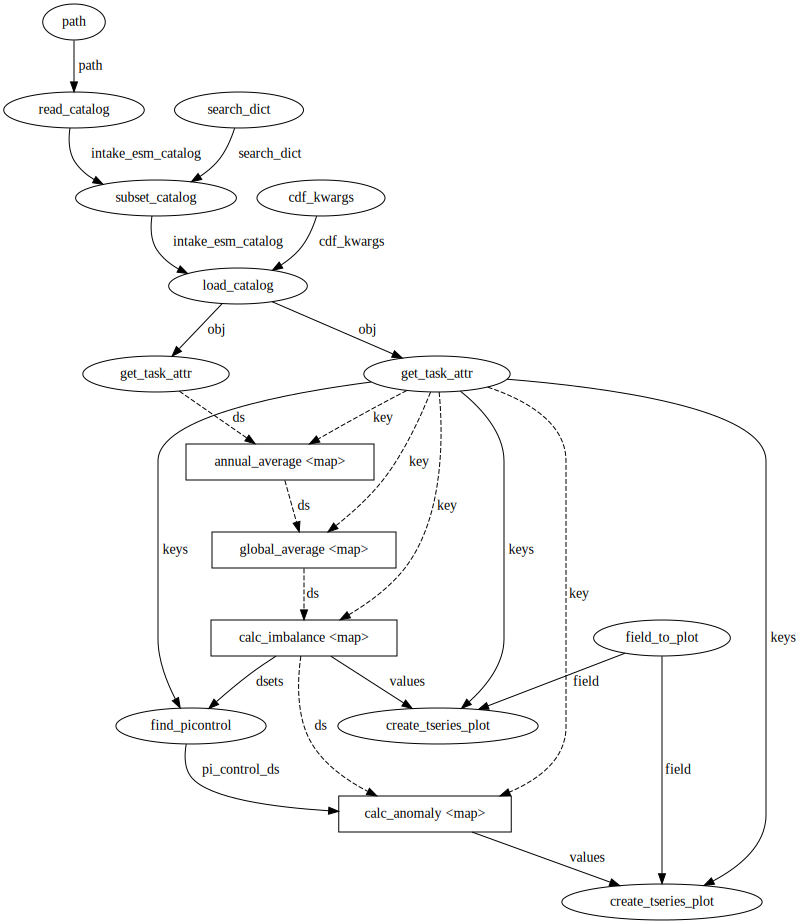

In [68]:
ecs_flow.visualize()

### Run our Prefect Flow
Now, we can run our flow!

We start with the same `query` we used before

[2021-12-23 14:31:28-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'ecs_flow'
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'search_dict': Starting task run...
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'search_dict': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'cdf_kwargs': Starting task run...
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'cdf_kwargs': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'path': Starting task run...
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'path': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'field_to_plot': Starting task run...
[2021-12-23 14:31:28-0700] INFO - prefect.TaskRunner | Task 'field_to_plot': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:2

[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'load_catalog': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'get_task_attr': Starting task run...
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'get_task_attr': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'get_task_attr': Starting task run...
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'get_task_attr': Finished task run for task with final state: 'Success'
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'annual_average': Starting task run...
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'annual_average': Finished task run for task with final state: 'Mapped'
[2021-12-23 14:31:47-0700] INFO - prefect.TaskRunner | Task 'annual_average[0]': Starting task run...
[2021-12-23 14:32:07-0700] INFO - prefect.TaskRunner | Task 'annual_average[

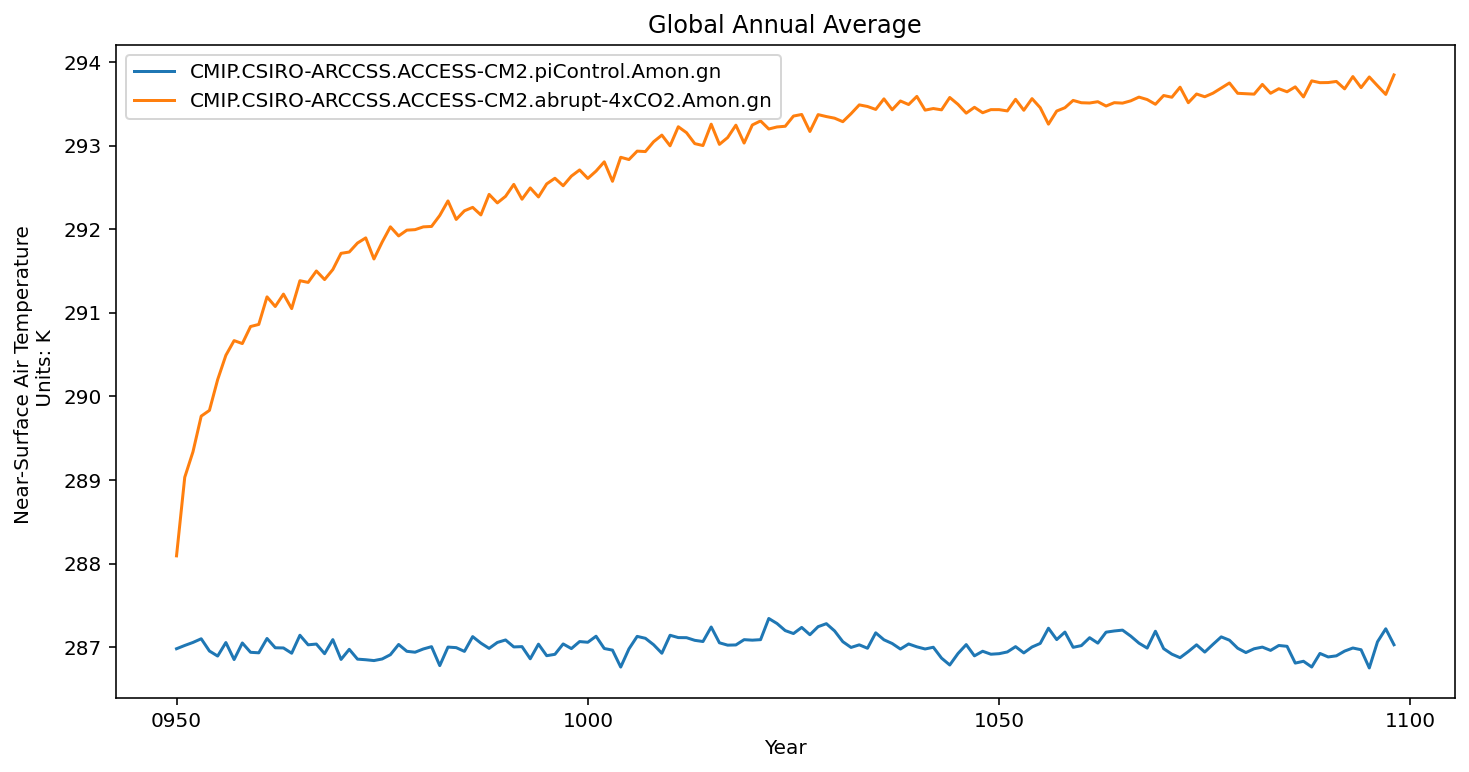

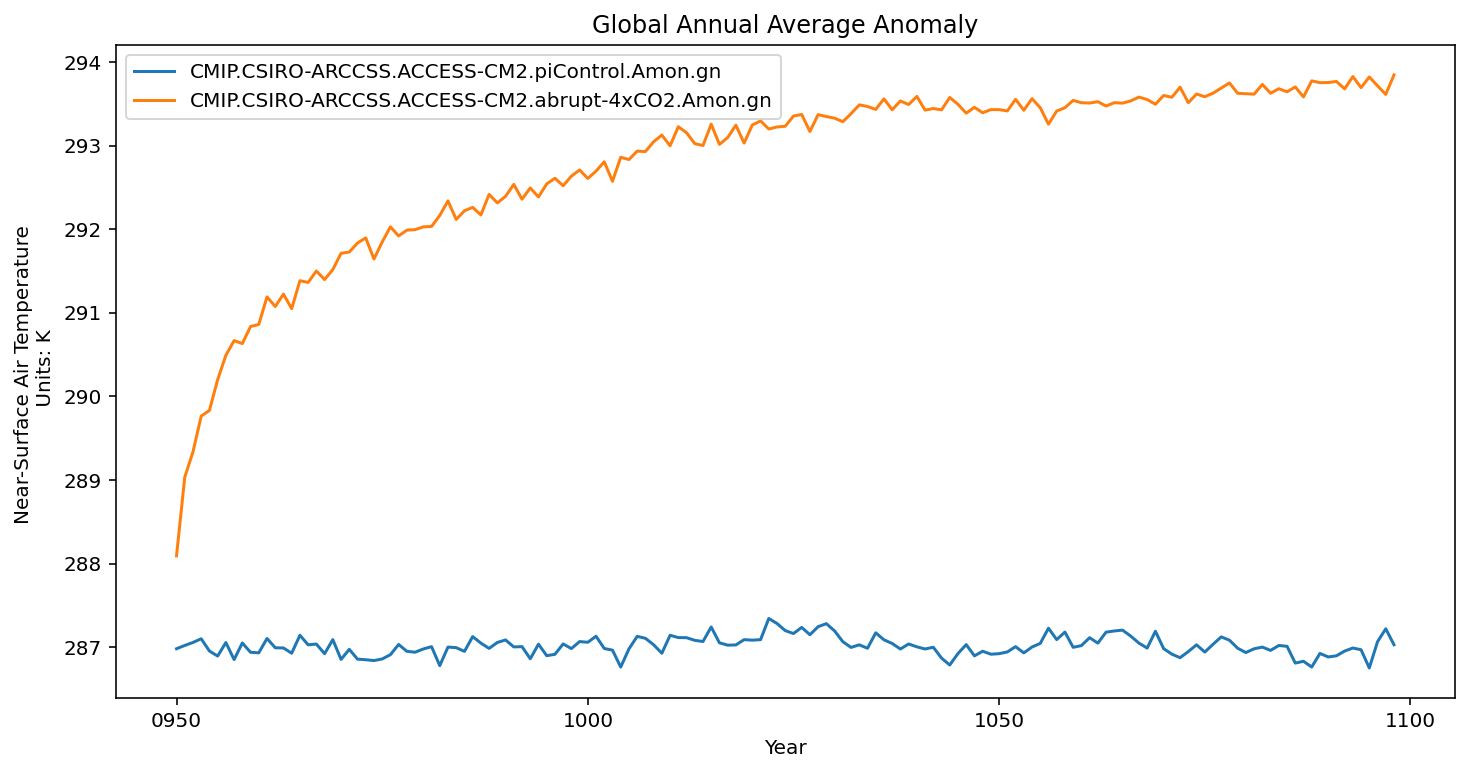

In [69]:
query = dict(
    experiment_id=[
        'abrupt-4xCO2',
        'piControl',
    ],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',  # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=[
        'tas',
        'rsut',
        'rsdt',
        'rlut',
    ],  # choose to look at near-surface air temperature (tas) as our variable
    member_id='r1i1p1f1',
    source_id='ACCESS-CM2',  # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)
executed_flow = ecs_flow.run(search_dict=query)

### Take a look at the plots
We use the `.result[task_name]` syntax here

#### Global Annual Average Plot

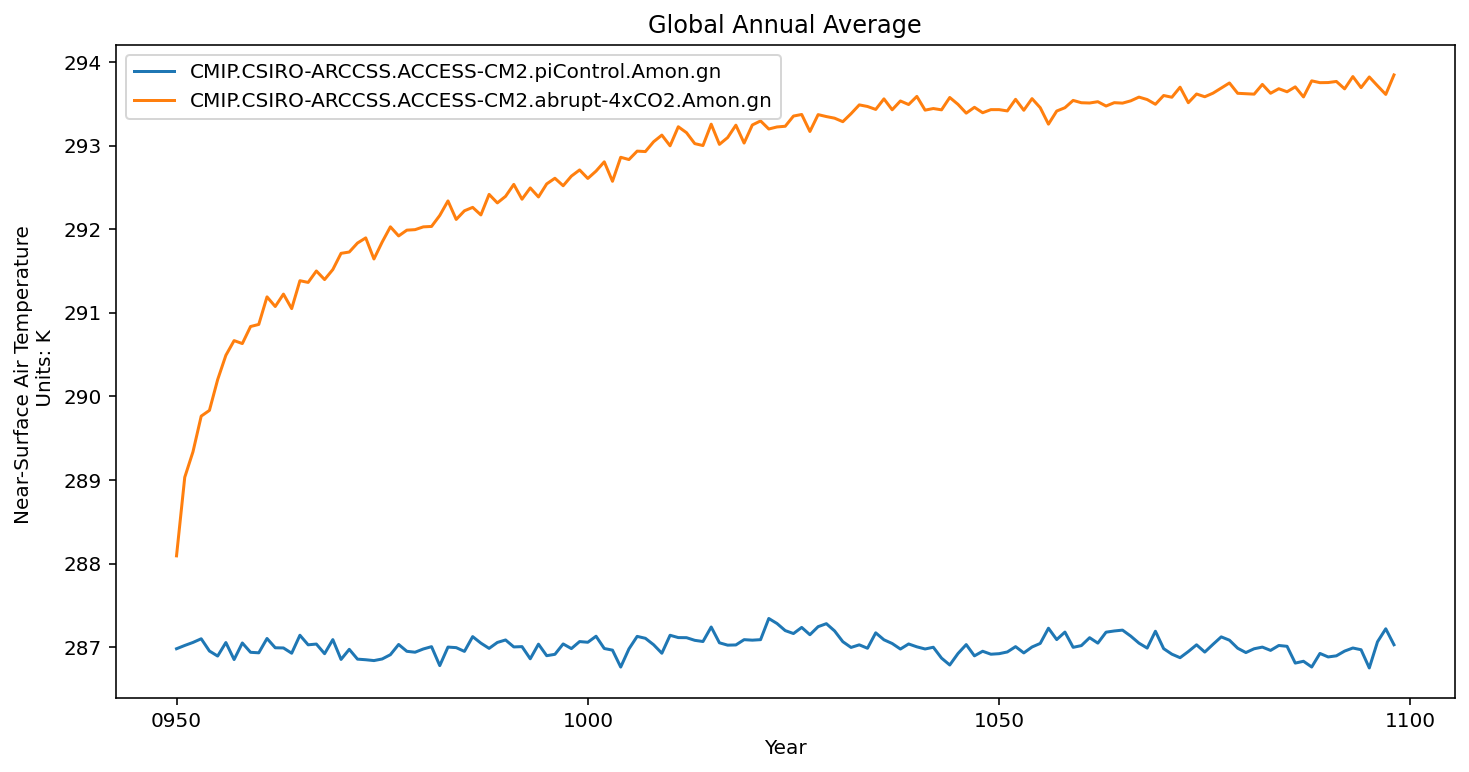

In [70]:
executed_flow.result[global_annual_timeseries_plot]._result.value

#### Global Annual Average Anomaly Plot

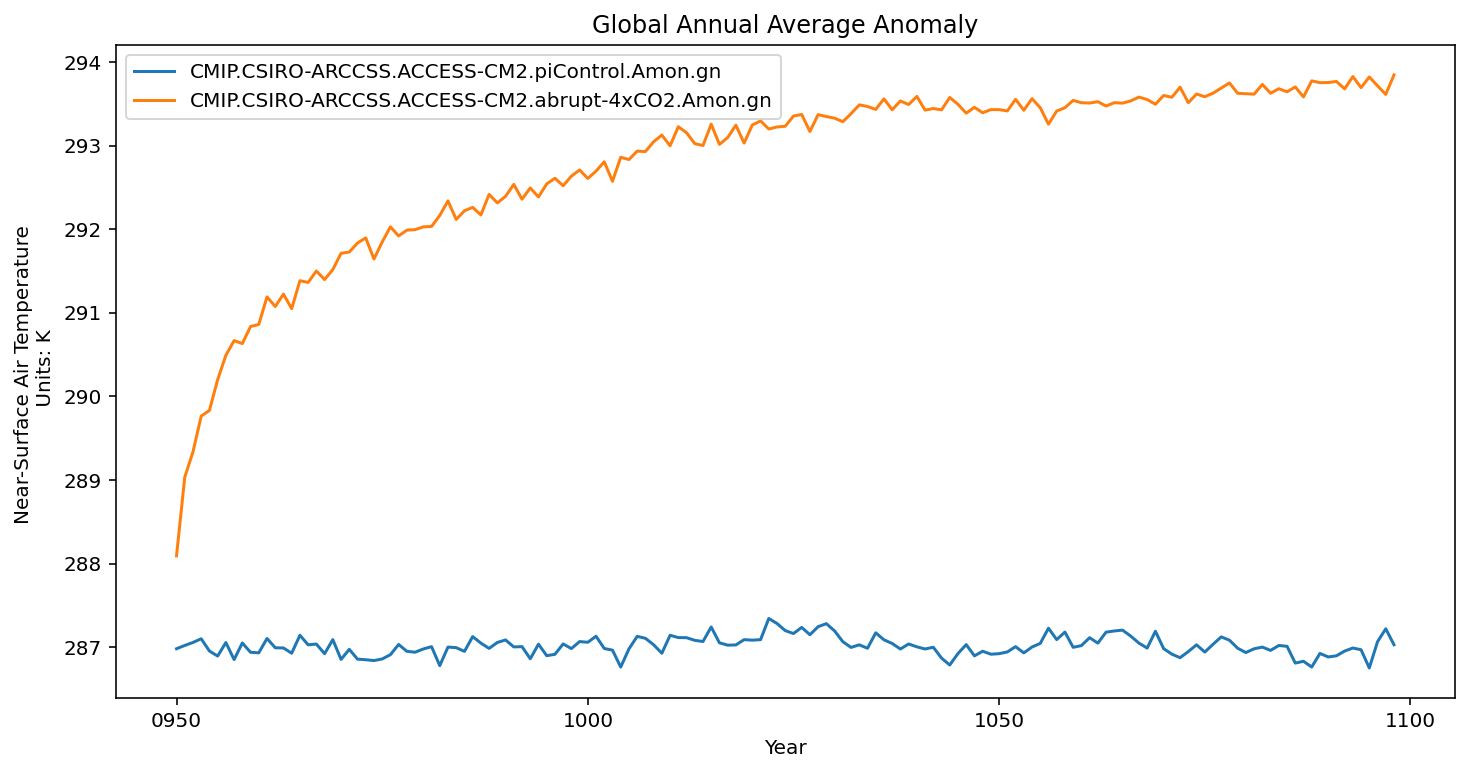

In [71]:
executed_flow.result[global_annual_timeseries_anomaly_plot]._result.value

### Investigating the Output
The result of our flow is the output shown above, as well as our `cache` (within the `store` variable), which we can investigate using `.keys()`

In [72]:
store.keys()

['ecs_flow-calc_anomaly-CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn.zarr',
 'ecs_flow-calc_imbalance-CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn.zarr',
 'ecs_flow-calc_imbalance-CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn.zarr',
 'ecs_flow-calc_anomaly-CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn.zarr']

If we wanted to read in one of these datasets, we can use `.get()`

In [73]:
store.get('ecs_flow-calc_anomaly-CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn.zarr')

<xarray.Dataset>
Dimensions:    (time: 150)
Coordinates:
    height     float64 ...
  * time       (time) object 0950-01-01 00:00:00 ... 1099-01-01 00:00:00
Data variables:
    imbalance  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>